In [4]:
import pandas as pd
import sys
import torch
import pytorch_lightning as pl
import matplotlib.pyplot as plt
import numpy as np
from pytorch_lightning.utilities.cli import LightningCLI

In [5]:
# Add the example model/etc.
import baseline_example
from baseline_example import InvestmentEulerBaseline

# utility to make calling with CLI defaults easier.  Does not log or use early stopping callbacks
def solve_model(Model, args, default_seed = 123):
    sys.argv = ["dummy.py"] + [f"--{key}={val}" for key, val in args.items()]  # hack overwriting  argv

    cli = LightningCLI(
        Model,
        run=False,
        seed_everything_default=default_seed,
        save_config_overwrite=True,        
        parser_kwargs={"default_config_files": ["baseline_example_defaults.yaml"]},
    )
    # Solves the model
    trainer = cli.instantiate_trainer(
        logger=None,
        checkpoint_callback=None,
        callbacks=[],  # not using the early stopping/etc.
    )    
    trainer.fit(cli.model)

    # Calculates the "test" values for it
    trainer.test(cli.model)
    cli.model.eval()  # Turn off training mode, where it calculates gradients for every call.

    return cli.model, cli
    

In [11]:
# Load using the cli options, then run to fit the model 
model, cli = solve_model(InvestmentEulerBaseline, {"trainer.max_epochs" : 5, "model.L" : 4, "model.verbose": True})

Global seed set to 123
GPU available: True, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
GPU available: True, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs

  | Name | Type       | Params
------------------------------------
0 | rho  | Sequential | 50.3 K
1 | phi  | Sequential | 17.3 K
------------------------------------
67.6 K    Trainable params
0         Non-trainable params
67.6 K    Total params
0.270     Total estimated model params size (MB)
C:\Users\jesse\anaconda3\lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:617: UserWarning: Checkpoint directory c:\Users\jesse\Documents\GitHub\symmetry_dynamic_programming\checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")


LQ optima are: [ 0.06872244 -0.05046136  0.        ]
Testing:  98%|█████████▊| 63/64 [00:03<00:00, 20.42it/s]--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 8.05152922112029e-06,
 'test_u_abs_error': 0.00016383636102546006,
 'test_u_rel_error': 0.005002937279641628}
--------------------------------------------------------------------------------
Testing: 100%|██████████| 64/64 [00:03<00:00, 20.39it/s]


Text(0.5, 0, 'Time($t$)')

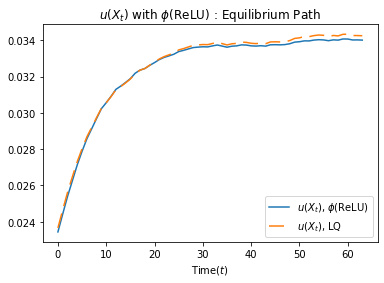

In [14]:
# Plot the results of the previous cell
df = model.test_results[
    model.test_results["ensemble"] == 0
]  # first ensemble in dataframe from model on test data

fig, ax = plt.subplots()
ax.plot(df["t"], df["u_hat"], label=r"$u(X_t)$, $\phi($ReLU$)$")
if model.hparams.nu == 1.0:  # only add reference line if linear
    ax.plot(df["t"], df["u_reference"], dashes=[10, 5, 10, 5], label=r"$u(X_t)$, LQ")
ax.legend()
ax.set_title(r"$u(X_t)$ with $\phi($ReLU$)$ : Equilibrium Path")
ax.set_xlabel(r"Time($t$)")


In [13]:
# Example to evaluate  model after fitting it, can do at multiple points at same time:
model.eval()  # TODO: why is the `no_grad` also needed?
X_points = torch.stack((model.X_0 + 0.001 * torch.randn(model.hparams.N),
                        model.X_0 + 0.05 * torch.ones(model.hparams.N)))
# evaluate the policy.  Doing it with a `no_grad` can speed things up 
with torch.no_grad():
    u_X = model(X_points)
    print(u_X)

tensor([[0.0234],
        [0.0211]])
